In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

In [30]:
df = pd.read_csv("semen.csv", low_memory=False, encoding ='utf8',sep=",")
df.head()

,ID,Sperm concentration (x10⁶/mL),Total sperm count (x10⁶),Ejaculate volume (mL),Sperm vitality (%),Normal spermatozoa (%),Head defects (%),Midpiece and neck defects (%),Tail defects (%),Cytoplasmic droplet (%),Teratozoospermia index,Progressive motility (%),Non progressive sperm motility (%),Immotile sperm (%),"High DNA stainability, HDS (%)","DNA fragmentation index, DFI (%)"
0,11,97.0,129.0,1.3,80,2.4,97.0,28.0,9.7,7.3,1.45,11,17,72,6,24
1,12,29.4,213.9,7.3,94,2.5,96.0,33.3,14.9,6.5,1.55,33,54,13,10,8
2,13,74.4,136.1,1.8,88,3.9,96.0,31.0,5.8,3.9,1.42,33,30,37,10,4
3,14,3.8,6.9,1.8,96,4.0,96.0,36.0,17.0,7.5,1.63,41,43,16,13,15
4,15,4.0,5.8,1.4,93,0.0,100.0,50.5,21.5,6.0,1.78,15,46,39,27,28


In [31]:
print(df.columns)

Index(['ID', 'Sperm concentration (x10⁶/mL)', 'Total sperm count (x10⁶)',
       'Ejaculate volume (mL)', 'Sperm vitality (%)', 'Normal spermatozoa (%)',
       'Head defects (%)', 'Midpiece and neck defects (%)', 'Tail defects (%)',
       'Cytoplasmic droplet (%)', 'Teratozoospermia index',
       'Progressive motility (%)', 'Non progressive sperm motility (%)',
       'Immotile sperm (%)', 'High DNA stainability, HDS (%)',
       'DNA fragmentation index, DFI (%)'],
      dtype='object')


In [32]:
# Retrieve the remaining dataset as X and y values
X = df.drop('Immotile sperm (%)', axis=1).values
y = df['Immotile sperm (%)'].values

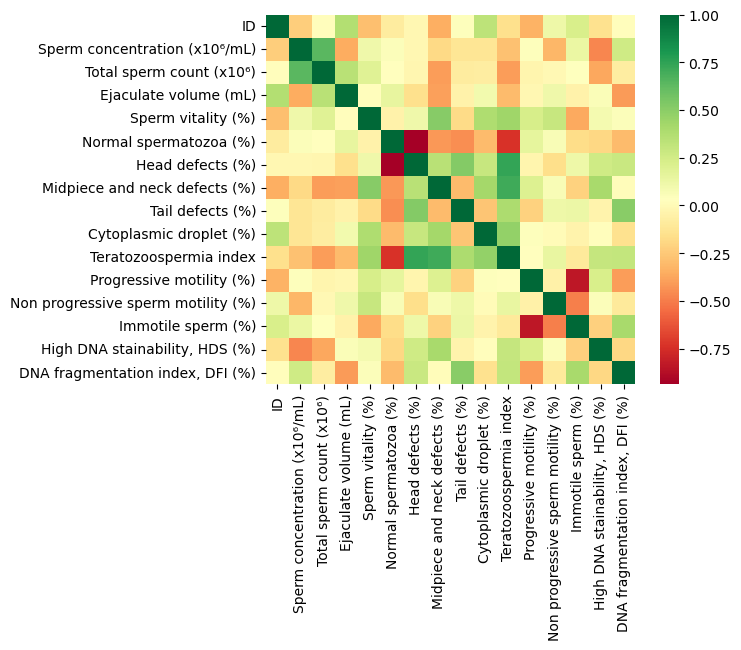

In [ ]:
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')

plt.show()

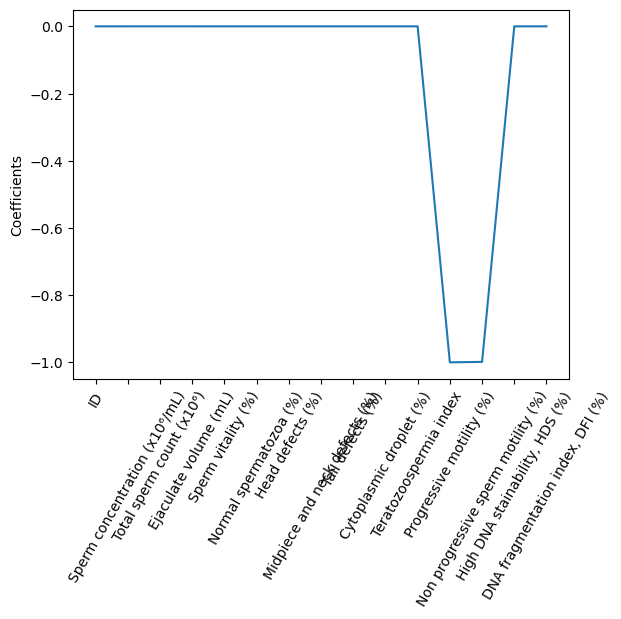

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

# Use a Lasso Regression to find the features that are most important
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

features = df.drop('Immotile sperm (%)', axis=1).columns
lasso = Lasso(alpha=0.1)
lasso_coef = lasso.fit(X_train, y_train).coef_

_ = plt.plot(range(len(features)), lasso_coef)
_ = plt.xticks(range(len(features)), features, rotation=60)
_ = plt.ylabel('Coefficients')
plt.show()

In [17]:
import matplotlib.pyplot as plt #visualization
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

plt.style.use('fivethirtyeight')

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 1.1 MB/s eta 0:00:0000:0100:04
Note: you may need to restart the kernel to use updated packages.


In [18]:
#Code By Ryan Holbrook

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [19]:
!pip install dash

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 1.5 MB/s eta 0:00:0000:0100:01


In [20]:
#PCA analysis in Dash

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA



app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id="graph"),
    html.P("Number of components:"),
    dcc.Slider(
        id='slider',
        min=2, max=5, value=3,
        marks={i: str(i) for i in range(2,6)})
])
@app.callback(
    Output("graph", "figure"), 
    [Input("slider", "value")])
def run_and_plot(n_components):

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(df)

    var = pca.explained_variance_ratio_.sum() * 100

    labels = {str(i): f"PC {i+1}" 
              for i in range(n_components)}
    labels['color'] = 'Immotile sperm (%)'

    fig = px.scatter_matrix(
        components,
        color=df.quality,
        dimensions=range(n_components),
        labels=labels,
        title=f'Total Explained Variance: {var:.2f}%')
    fig.update_traces(diagonal_visible=False)
    return fig
app.run_server(debug=True)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: on


Traceback (most recent call last):
  File "/opt/intel/inteloneapi/tensorflow/latest/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/glob/development-tools/versions/oneapi/2023.1.1/oneapi/tensorflow/2.12.0/lib/python3.9/site-packages/traitlets/config/application.py", line 1042, in launch_instance
    app.initialize(argv)
  File "/glob/development-tools/versions/oneapi/2023.1.1/oneapi/tensorflow/2.12.0/lib/python3.9/site-packages/traitlets/config/application.py", line 113, in inner
    return method(app, *args, **kwargs)
  File "/glob/development-tools/versions/oneapi/2023.1.1/oneapi/tensorflow/2.12.0/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 678, in initialize
    self.init_sockets()
  File "/glob/development-tools/versions/oneapi/2023.1.1/oneapi/tensorflow/2.12.0/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 317, in init_sockets
    self.shell_port = self._bind_socket(self.shell_socket, self.she

SystemExit: 1

In [37]:
print(df.columns)

Index(['ID', 'Sperm concentration (x10⁶/mL)', 'Total sperm count (x10⁶)',
       'Ejaculate volume (mL)', 'Sperm vitality (%)', 'Normal spermatozoa (%)',
       'Head defects (%)', 'Midpiece and neck defects (%)', 'Tail defects (%)',
       'Cytoplasmic droplet (%)', 'Teratozoospermia index',
       'Progressive motility (%)', 'Non progressive sperm motility (%)',
       'Immotile sperm (%)', 'High DNA stainability, HDS (%)',
       'DNA fragmentation index, DFI (%)'],
      dtype='object')


In [ ]:
#Visualize PCA with px.scatter_3d

X = df[["Sperm concentration (x10⁶/mL)", "Tail defects (%)", "Sperm vitality (%)"]]

pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=2, y=2, z=2, color=df['Immotile sperm (%)'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()